# ENEL 645 - Deep Learning
## AutoML & HPO Tutorial
- By: Mike Lasby
- 2022-03-03

In [4]:
%matplotlib inline

In [2]:
# Common imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import math
import pathlib
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [3]:
# Notebook constants that we will return to 
# TODO: What is name mangling? 
# TODO: Benefits of pathlib?
__DATA_PATH = pathlib.Path("./data")
__RANDOM_STATE = 42

### AutoML with TPOT
http://epistasislab.github.io/tpot/

TPOT is a Python Automated Machine Learning tool that optimizes machine learning pipelines using genetic programming.


In [4]:
X, y = load_iris(return_X_y=True, as_frame=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=__RANDOM_STATE)
X_train.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
81,5.5,2.4,3.7,1.0
133,6.3,2.8,5.1,1.5
137,6.4,3.1,5.5,1.8
75,6.6,3.0,4.4,1.4
109,7.2,3.6,6.1,2.5


In [5]:
from sklearn.decomposition import PCA
pca = PCA(random_state=__RANDOM_STATE, n_components=2)
X_pca = pca.fit_transform(X)
df = pd.DataFrame(np.concatenate((X_pca, y.values.reshape(-1,1)), axis=1),
                  columns=[
                      "Principal component 1",
                      "Principal component 2",
                      "Label",
                  ],
).astype({"Label": "category"})
fig = px.scatter(df, x="Principal component 1", y="Principal component 2", color="Label")
fig.update_layout(title="PCA of Iris Dataset", title_x=0.5)
fig.update_xaxes(title="Principal Component 1")
fig.update_yaxes(title="Principal Component 2")
fig.show()

# TODO: What does the position of the components signify?

In [6]:
from tpot import TPOTClassifier
classifier = TPOTClassifier(
    n_jobs=-1,   # Use all availabe cores
    scoring='accuracy',
    max_time_mins=5,  # Can set max time limit
    random_state=__RANDOM_STATE, 
    verbosity=2, 
)
classifier.fit(X_train, y_train)

C:\Users\Mike\anaconda3\envs\automl\lib\site-packages\tpot\builtins\__init__.py:36: UserWarning:


C:\Users\Mike\anaconda3\envs\automl\lib\site-packages\xgboost\compat.py:36: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



                                                                              
Generation 1 - Current best internal CV score: 0.9619047619047618
                                                                              
Generation 2 - Current best internal CV score: 0.980952380952381
                                                                              
Generation 3 - Current best internal CV score: 0.980952380952381
                                                                              
Generation 4 - Current best internal CV score: 0.980952380952381
                                                                              
Generation 5 - Current best internal CV score: 0.980952380952381
                                                                              
Generation 6 - Current best internal CV score: 0.980952380952381
                                                                              
Generation 7 - Current best internal CV score: 0.9809523

TPOTClassifier(max_time_mins=5, n_jobs=-1, random_state=42, scoring='accuracy',
               verbosity=2)

In [20]:
acc = classifier.score(X_test, y_test)
print(f"Accuracy score with TPOT classifier: {acc*100:.2f}%")
classifier.export("./exported_tpot_model.py")

Accuracy score with TPOT classifier: 100.00%


### AutoML with AutoKeras
Theory: https://arxiv.org/abs/1806.10282

"Framework enabling Bayesian optimization to guide the network morphism for efficient neural architecture search. The framework develops a neural network kernel and a tree-structured acquisition function optimization algorithm to efficiently explores the search space. Intensive experiments on real-world benchmark datasets have been done to demonstrate the superior performance of the developed framework over the state-of-the-art methods. Moreover, we build an opensource AutoML system based on our method, namely Auto-Keras."

"The system runs in parallel on CPU and GPU, with an adaptive search strategy for different GPU memory limits."

API: https://autokeras.com/

In [52]:
import autokeras as ak
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
X_train_tiny, _, y_train_tiny, _ = train_test_split(
  X_train, y_train, train_size=0.1,
  random_state=__RANDOM_STATE
  )

# We will search over 5000 training images only.
# Then we can fine-tune the best model using entire dataset. 
# TODO: This is an example of _____? architecture evaluation. 

"""
  | Label | Description |
  |:-----:|-------------|
  |   0   | airplane    |
  |   1   | automobile  |
  |   2   | bird        |
  |   3   | cat         |
  |   4   | deer        |
  |   5   | dog         |
  |   6   | frog        |
  |   7   | horse       |
  |   8   | ship        |
  |   9   | truck       |
"""
labels = {
    0:  "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",    
    4: "deer",     
    5: "dog",    
    6: "frog",     
    7: "horse",    
    8: "ship",   
    9: "truck",
}

In [5]:
pd.DataFrame(y_train_tiny).value_counts()

7    534
4    524
0    510
6    505
5    503
2    502
8    499
1    487
3    474
9    462
dtype: int64

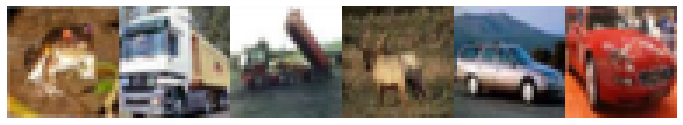

['frog', 'truck', 'truck', 'deer', 'automobile', 'automobile']


In [7]:
from functools import reduce
# TODO: What does reduce do?
def image_row(x):
        images = tf.unstack(x)
        row = reduce(lambda a,b: tf.concat((a,b), axis=1), images)
        return row

n_images = 6
images = image_row(X_train[:n_images])
plt.figure(figsize=(12,8))
plt.imshow(images)
plt.axis("off")
plt.show()
print(f"{[labels[l] for l in y_train[:n_images].flatten()]}")

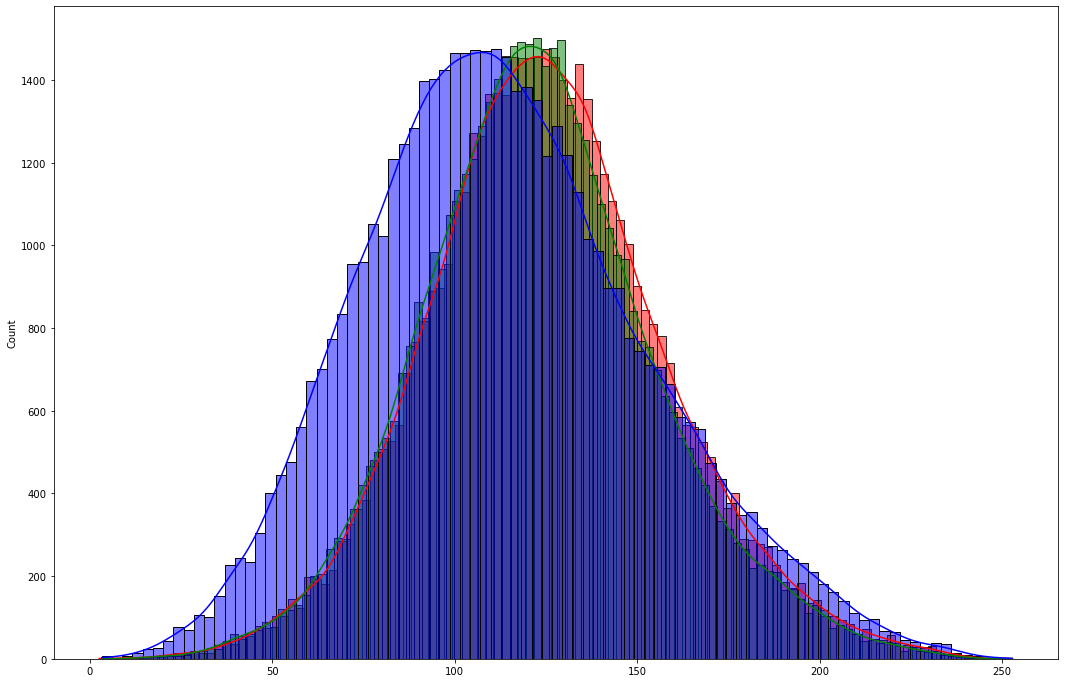

In [9]:
plt.figure(figsize=(18,12))
# TODO: Seaborn has the best histograms
sns.histplot(X_train.mean(axis=(1,2))[:,0], kde=True, color="red")
sns.histplot(X_train.mean(axis=(1,2))[:,1], kde=True, color="green")
sns.histplot(X_train.mean(axis=(1,2))[:,2], kde=True, color="blue")
plt.show()

In [85]:
# We will customize our search space to only consider smaller "vanilla" convolutional models
input_node = ak.ImageInput()
output_node = ak.ImageBlock(
    # Only search Vanilla Conv architectures.
    block_type="vanilla",  # Custom block used to populate hypermodel
    # Normalize the dataset.
    normalize=True,
    # Perform augmentation
    augment=True,
)(input_node)
output_node = ak.ClassificationHead()(output_node)
clf = ak.AutoModel(
    inputs=input_node, outputs=output_node, overwrite=True, max_trials=100,
    directory= __DATA_PATH / "vanilla-conv", seed=__RANDOM_STATE, objective="val_accuracy"  # TODO: Note __truediv__ behavior of Path
)

In [86]:
clf.fit(X_train_tiny, y_train_tiny, epochs=5)  # TODO: Fit 100 models for 5 epochs each!

Trial 100 Complete [00h 00m 06s]
val_accuracy: 0.567148745059967

Best val_accuracy So Far: 0.5950413346290588
Total elapsed time: 00h 11m 15s
INFO:tensorflow:Oracle triggered exit


Epoch 1/5
157/157 [==============================] - 2s 7ms/step - loss: 1.8478 - accuracy: 0.3304
Epoch 2/5
157/157 [==============================] - 1s 7ms/step - loss: 1.5362 - accuracy: 0.4428
Epoch 3/5
157/157 [==============================] - 1s 7ms/step - loss: 1.4253 - accuracy: 0.4868
Epoch 4/5
157/157 [==============================] - 1s 7ms/step - loss: 1.3085 - accuracy: 0.5284
Epoch 5/5
157/157 [==============================] - 1s 7ms/step - loss: 1.2459 - accuracy: 0.5580
INFO:tensorflow:Assets written to: data\vanilla-conv\auto_model\best_model\assets


In [87]:
trials = clf.tuner.oracle.get_best_trials(num_trials=-1)
data = {
    "Trial": [],
    "Score": []
}
for i, t in enumerate(trials):
    data["Trial"].append(i)
    data["Score"].append(t.score)
px.bar(data_frame=pd.DataFrame(data), x="Trial", y="Score")

In [91]:
import pickle

# with open(__DATA_PATH / "vanilla-conv" / "ak_clf_van_conv.pkl", "wb") as handle:
#     pickle.dump(clf, handle, protocol=pickle.HIGHEST_PROTOCOL)


# with open(__DATA_PATH / "vanilla-conv" / "ak_clf_van_conv.pkl", "rb") as handle:
#     clf = pickle.load(handle)

In [111]:
model = clf.tuner.get_best_model()  # TODO: Take a look at the best model we found
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 cast_to_float32 (CastToFloa  (None, 32, 32, 3)        0         
 t32)                                                            
                                                                 
 normalization (Normalizatio  (None, 32, 32, 3)        7         
 n)                                                              
                                                                 
 random_translation (RandomT  (None, 32, 32, 3)        0         
 ranslation)                                                     
                                                                 
 random_flip (RandomFlip)    (None, 32, 32, 3)         0         
                                                             

In [112]:
model.save(__DATA_PATH / "vanilla-conv" / "vanilla-conv-model")  # TODO: Save once your search is completed 

INFO:tensorflow:Assets written to: data\vanilla-conv\vanilla-conv-model\assets


In [101]:
loss, acc = clf.evaluate(X_test, y_test)
print(f"Accuracy score with AutoKeras classifier: {acc*100:.2f}%")  # Not so good, but only using 10% of data


313/313 [==============================] - 1s 3ms/step - loss: 1.2606 - accuracy: 0.5681
Accuracy score with AutoKeras classifier: 56.81%


In [102]:
clf.export_model()  # Another option autokeras specific to export model

In [23]:
# https://github.com/keras-team/autokeras/blob/master/autokeras/auto_model.py 
# TODO: Let's try to fine tune the best vanilla model

# See auto_model.py source, we want to make use of adapt method for auto preprocessing.

def ak_get_dataset(X,y,clf):
    x = clf._adapt(X, clf.inputs, 32)
    y = clf._adapt(y, clf._heads, 32)
    dataset = tf.data.Dataset.zip((x, y))
    pipeline = clf.tuner.get_best_pipeline()
    dataset = pipeline.transform(dataset)
    return dataset

train_split = int(0.8 * len(X_train))
train_dataset = ak_get_dataset(X_train[:train_split], y_train[:train_split], clf)
val_dataset = ak_get_dataset(X_train[train_split:], y_train[train_split:], clf)
test_dataset = ak_get_dataset(X_test, y_test, clf)

In [172]:
# Let's try fully training for a few epochs:
# tf.config.run_functions_eagerly(True)
model = tf.keras.models.load_model(__DATA_PATH / "vanilla-conv" / "vanilla-conv-model")
history = model.fit(train_dataset, batch_size=32, epochs=10, validation_data=val_dataset)

Epoch 1/10
1563/1563 [==============================] - 83s 53ms/step - loss: 1.1628 - accuracy: 0.5957 - val_loss: 0.9500 - val_accuracy: 0.6756
Epoch 2/10
1563/1563 [==============================] - 82s 53ms/step - loss: 1.0128 - accuracy: 0.6505 - val_loss: 0.8359 - val_accuracy: 0.7141
Epoch 3/10
1563/1563 [==============================] - 82s 53ms/step - loss: 0.9226 - accuracy: 0.6801 - val_loss: 0.7606 - val_accuracy: 0.7378
Epoch 4/10
1563/1563 [==============================] - 82s 52ms/step - loss: 0.8690 - accuracy: 0.6984 - val_loss: 0.7154 - val_accuracy: 0.7563
Epoch 5/10
1563/1563 [==============================] - 83s 53ms/step - loss: 0.8342 - accuracy: 0.7111 - val_loss: 0.6769 - val_accuracy: 0.7692
Epoch 6/10
1563/1563 [==============================] - 82s 53ms/step - loss: 0.7988 - accuracy: 0.7258 - val_loss: 0.6500 - val_accuracy: 0.7768
Epoch 7/10
1563/1563 [==============================] - 82s 53ms/step - loss: 0.7770 - accuracy: 0.7323 - val_loss: 0.6440 -

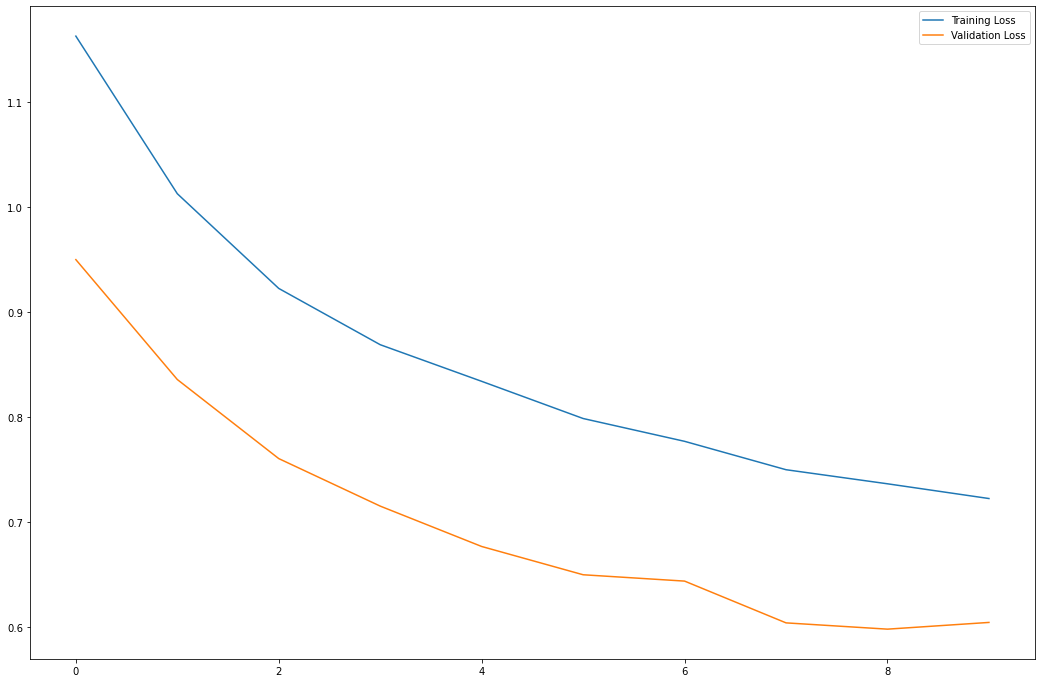

In [180]:
plt.figure(figsize=(18,12))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

In [193]:
from sklearn.metrics import accuracy_score
y_pred = model.predict(test_dataset)
acc = accuracy_score(y_test, y_pred.argmax(axis=1))
print(f"Accuracy score with AutoKeras classifier after full dataset fit: {acc*100:.2f}%")  # Pretty good for 10 epochs! More to improve

Accuracy score with AutoKeras classifier after full dataset fit: 75.88%


# What about larger models?


In [5]:
from autokeras.tuners import task_specific
for hp in task_specific.IMAGE_CLASSIFIER:
    print(f"{hp}\n")
# NOTE: This is the default tuner initial hyper params. Note block types.

{'image_block_1/block_type': 'vanilla', 'image_block_1/normalize': True, 'image_block_1/augment': False, 'image_block_1/conv_block_1/kernel_size': 3, 'image_block_1/conv_block_1/num_blocks': 1, 'image_block_1/conv_block_1/num_layers': 2, 'image_block_1/conv_block_1/max_pooling': True, 'image_block_1/conv_block_1/separable': False, 'image_block_1/conv_block_1/dropout': 0.25, 'image_block_1/conv_block_1/filters_0_0': 32, 'image_block_1/conv_block_1/filters_0_1': 64, 'classification_head_1/spatial_reduction_1/reduction_type': 'flatten', 'classification_head_1/dropout': 0.5, 'optimizer': 'adam', 'learning_rate': 0.001}

{'image_block_1/block_type': 'resnet', 'image_block_1/normalize': True, 'image_block_1/augment': True, 'image_block_1/image_augmentation_1/horizontal_flip': True, 'image_block_1/image_augmentation_1/vertical_flip': True, 'image_block_1/image_augmentation_1/contrast_factor': 0.0, 'image_block_1/image_augmentation_1/rotation_factor': 0.0, 'image_block_1/image_augmentation_1/t

In [7]:
import autokeras as ak
clf = ak.ImageClassifier(max_trials=5, directory=__DATA_PATH, seed=__RANDOM_STATE,
                         overwrite=True, objective="val_accuracy")
clf.fit(X_train_tiny, y_train_tiny, epochs=1)

Trial 5 Complete [00h 07m 01s]
val_accuracy: 0.11053719371557236

Best val_accuracy So Far: 0.7871900796890259
Total elapsed time: 00h 19m 49s
INFO:tensorflow:Oracle triggered exit


Not enough memory, reduce batch size to 16.
Not enough memory, reduce batch size to 8.
Not enough memory, reduce batch size to 4.
1250/1250 [==============================] - 414s 331ms/step - loss: 1.4428 - accuracy: 0.5424
INFO:tensorflow:Assets written to: data\image_classifier\best_model\assets


In [12]:
trials = clf.tuner.oracle.get_best_trials(num_trials=-1)
data = {
    "Trial": [],
    "Score": []
}
for i, t in enumerate(trials):
    data["Trial"].append(i)
    data["Score"].append(t.score)
px.bar(data_frame=pd.DataFrame(data), x="Trial", y="Score")

In [13]:
model = clf.tuner.get_best_models()[0]
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 cast_to_float32 (CastToFloa  (None, 32, 32, 3)        0         
 t32)                                                            
                                                                 
 normalization (Normalizatio  (None, 32, 32, 3)        7         
 n)                                                              
                                                                 
 random_translation (RandomT  (None, 32, 32, 3)        0         
 ranslation)                                                     
                                                                 
 random_flip (RandomFlip)    (None, 32, 32, 3)         0         
                                                             

In [ ]:
# NOTE: A few more params than our vanilla model!

In [14]:
import pickle
with open(__DATA_PATH / "image_classifier" / "ak_clf_eff_net.pkl", "wb") as handle:
    pickle.dump(clf, handle, protocol = pickle.HIGHEST_PROTOCOL)

# with open(__DATA_PATH / "image_classifier" / "ak_clf_eff_net.pkl", "wb") as handle:
#     clf = pickle.load(handle)

In [20]:
clf.tuner.search_space_summary()  # NOTE: Large search space! Will take hours to days to explore fully.

Search space summary
Default search space size: 28
image_block_1/normalize (Boolean)
{'default': False, 'conditions': []}
image_block_1/augment (Boolean)
{'default': False, 'conditions': []}
image_block_1/block_type (Choice)
{'default': 'resnet', 'conditions': [], 'values': ['resnet', 'xception', 'vanilla', 'efficient'], 'ordered': False}
image_block_1/res_net_block_1/pretrained (Boolean)
{'default': False, 'conditions': [{'class_name': 'Parent', 'config': {'name': 'image_block_1/block_type', 'values': ['resnet']}}]}
image_block_1/res_net_block_1/version (Choice)
{'default': 'resnet50', 'conditions': [{'class_name': 'Parent', 'config': {'name': 'image_block_1/block_type', 'values': ['resnet']}}], 'values': ['resnet50', 'resnet101', 'resnet152', 'resnet50_v2', 'resnet101_v2', 'resnet152_v2'], 'ordered': False}
image_block_1/res_net_block_1/imagenet_size (Boolean)
{'default': False, 'conditions': [{'class_name': 'Parent', 'config': {'name': 'image_block_1/block_type', 'values': ['resnet'

In [24]:
from sklearn.metrics import accuracy_score
test_dataset = ak_get_dataset(X_test, y_test, clf)
y_pred = model.predict(test_dataset)
acc = accuracy_score(y_test, y_pred.argmax(axis=1))
print(f"Accuracy score with AutoKeras-Efficient-Net classifier after full dataset fit: {acc*100:.2f}%")  # Single epoch score! 

Accuracy score with AutoKeras-Efficient-Net classifier after full dataset fit: 76.92%


### HPO with Keras Tuner

In [21]:
clf.tuner.oracle.hyperparameters.space
# NOTE: AutoKeras and Keras Tuner are closely related. (AK depends on Keras Tuner). These hyperparameters define search space.

[Boolean(name: "image_block_1/normalize", default: False),
 Boolean(name: "image_block_1/augment", default: False),
 Choice(name: "image_block_1/block_type", values: ['resnet', 'xception', 'vanilla', 'efficient'], ordered: False, default: resnet),
 Boolean(name: "image_block_1/res_net_block_1/pretrained", default: False),
 Choice(name: "image_block_1/res_net_block_1/version", values: ['resnet50', 'resnet101', 'resnet152', 'resnet50_v2', 'resnet101_v2', 'resnet152_v2'], ordered: False, default: resnet50),
 Boolean(name: "image_block_1/res_net_block_1/imagenet_size", default: False),
 Choice(name: "classification_head_1/spatial_reduction_1/reduction_type", values: ['flatten', 'global_max', 'global_avg'], ordered: False, default: flatten),
 Choice(name: "classification_head_1/dropout", values: [0.0, 0.25, 0.5], ordered: True, default: 0),
 Choice(name: "optimizer", values: ['adam', 'sgd', 'adam_weight_decay'], ordered: False, default: adam),
 Choice(name: "learning_rate", values: [0.1, 0.

In [75]:
import keras_tuner as kt

"""
NOTE: each Keras Application expects a specific kind of input preprocessing.
For EfficientNet, input preprocessing is included as part of the model (as a
Rescaling layer), and thus tf.keras.applications.efficientnet.preprocess_input
is actually a pass-through function. EfficientNet models expect their inputs to
be float tensors of pixels with values in the [0-255] range.
"""

def get_eff_net_backbone_model(units, activation, dropout, lr):
    eff_net = tf.keras.applications.efficientnet.EfficientNetB0(
        include_top=False,  # We are applying to new problem and will train our own classifier
        weights="imagenet",
        input_shape = (32,32,3),  #NHWC
        classes=10,
    )
    eff_net.trainable = False
    input = tf.keras.Input(shape=(32,32,3), name = "input")
    x = eff_net(input)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(units)(x)
    x = tf.keras.layers.Activation(activation)(x)
    if dropout:
        x = tf.keras.layers.Dropout(rate=0.25)(x)
    x = tf.keras.layers.Dense(10)(x)
    x = tf.keras.layers.Activation("softmax")(x)
    model = tf.keras.Model(inputs=input,
                        outputs=x,
                        name="eff_net_cifar10")
    model.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr),
        loss='categorical_crossentropy',
        metrics="accuracy"
    )
    return model

def build_hypermodel(hp):
    units = hp.Int("units", min_value=32, max_value=512, step = 32)
    activation = hp.Choice("activation", ["relu", 'swish'])
    lr = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    dropout = hp.Boolean("dropout")
    model = get_eff_net_backbone_model(units, activation, dropout, lr)
    return model


model = build_hypermodel(kt.HyperParameters())
model.summary()

Model: "eff_net_cifar10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 32, 32, 3)]       0         
                                                                 
 efficientnetb0 (Functional)  (None, 1, 1, 1280)       4049571   
                                                                 
 flatten_1 (Flatten)         (None, 1280)              0         
                                                                 
 dense_4 (Dense)             (None, 32)                40992     
                                                                 
 activation_4 (Activation)   (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 10)                330       
                                                                 
 activation_5 (Activation)   (None, 10)            

In [ ]:
# NOTE: Lots of params, but mostly we are relying on image net weights for evaluating our different classifier heads.

In [70]:
y_train_ohe = tf.one_hot(y_train.flatten(), 10)  # We finally need to do some work of our own!
y_test_ohe = tf.one_hot(y_test.flatten(), 10)
y_train_tiny_ohe = tf.one_hot(y_train_tiny.flatten(), 10)

In [76]:
# TODO: Demo TF board if we have time
# tensorboard --logdir=logs --host localhost --port 8888
tf.config.run_functions_eagerly(False)
tb_callback = tf.keras.callbacks.TensorBoard("./logs")
tuner = kt.BayesianOptimization(
    hypermodel=build_hypermodel,
    max_trials=10,
    overwrite=True,
    objective="val_accuracy",
    directory = __DATA_PATH / "keras-tuner" / "test"
)

history = tuner.search(
    X_train_tiny,
    y_train_tiny_ohe,
    validation_split=0.2,
    epochs=2,
    callbacks=[tb_callback]
)

Trial 10 Complete [00h 00m 13s]
val_accuracy: 0.4580000042915344

Best val_accuracy So Far: 0.47600001096725464
Total elapsed time: 00h 02m 24s
INFO:tensorflow:Oracle triggered exit


In [ ]:
%load_ext tensorboard

In [37]:
tuner.results_summary()

Results summary
Results in data\keras-tuner\untitled_project
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
units: 512
activation: relu
lr: 0.0009079703969290101
dropout: False
Score: 0.49900001287460327
Trial summary
Hyperparameters:
units: 512
activation: swish
lr: 0.001165603833417284
dropout: False
Score: 0.46299999952316284
Trial summary
Hyperparameters:
units: 192
activation: relu
lr: 0.0014704979951629367
dropout: True
Score: 0.46000000834465027
Trial summary
Hyperparameters:
units: 256
activation: relu
lr: 0.0003724316163844953
dropout: True
Score: 0.4560000002384186
Trial summary
Hyperparameters:
units: 160
activation: relu
lr: 0.0006771925396670594
dropout: False
Score: 0.4359999895095825
Trial summary
Hyperparameters:
units: 480
activation: relu
lr: 0.0001
dropout: True
Score: 0.4099999964237213
Trial summary
Hyperparameters:
units: 512
activation: relu
lr: 0.01
dropout: True
Score: 0.40299999713897705
Trial summary
Hype

In [39]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'swish'], 'ordered': False}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}
dropout (Boolean)
{'default': False, 'conditions': []}


In [43]:
hp = tuner.get_best_hyperparameters()[0]
model_hp = tuner.hypermodel.build(hp)
model_hp.summary()

Model: "eff_net_cifar10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(32, 32, 32, 3)]         0         
                                                                 
 efficientnetb0 (Functional)  (None, 1, 1, 1280)       4049571   
                                                                 
 flatten_2 (Flatten)         (32, 1280)                0         
                                                                 
 dense_4 (Dense)             (32, 512)                 655872    
                                                                 
 activation_4 (Activation)   (32, 512)                 0         
                                                                 
 dense_5 (Dense)             (32, 10)                  5130      
                                                                 
 activation_5 (Activation)   (32, 10)              

In [40]:
model = tuner.get_best_models()[0]
model.summary()

Model: "eff_net_cifar10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(32, 32, 32, 3)]         0         
                                                                 
 efficientnetb0 (Functional)  (None, 1, 1, 1280)       4049571   
                                                                 
 flatten (Flatten)           (32, 1280)                0         
                                                                 
 dense (Dense)               (32, 512)                 655872    
                                                                 
 activation (Activation)     (32, 512)                 0         
                                                                 
 dense_1 (Dense)             (32, 10)                  5130      
                                                                 
 activation_1 (Activation)   (32, 10)              

In [68]:
# What about preprocessing? Define custom hypermodel with fit and build methods

import keras_tuner as kt

tf.config.run_functions_eagerly(False)

class EffnetHypermodel(kt.HyperModel):
    
    def __init__(self):
        super()
        
    
    def get_eff_net_backbone_model(self, units, activation, dropout, lr):
        eff_net = tf.keras.applications.efficientnet.EfficientNetB0(
            include_top=False,  # We are applying to new problem and will train our own classifier
            weights="imagenet",
            input_shape = (32,32,3),  #NHWC
            classes=10,
        )
        eff_net.trainable = False
        input = tf.keras.Input(shape=(32,32,3), batch_size=32, name = "input")
        x = eff_net(input)
        x = tf.keras.layers.Flatten()(x)
        x = tf.keras.layers.Dense(units)(x)
        x = tf.keras.layers.Activation(activation)(x)
        if dropout:
            x = tf.keras.layers.Dropout(rate=0.25)(x)
        x = tf.keras.layers.Dense(10)(x)
        x = tf.keras.layers.Activation("softmax")(x)
        model = tf.keras.Model(inputs=input,
                            outputs=x,
                            name="eff_net_cifar10")
        model.compile(
            optimizer = tf.keras.optimizers.Adam(learning_rate=lr),
            loss='categorical_crossentropy',
            metrics="accuracy"
        )
        return model

    #override: This method must be implemented as it will be called by tuner / oracle
    def build(self, hp):
        units = hp.Int("units", min_value=32, max_value=512, step = 32)
        activation = hp.Choice("activation", ["relu", 'swish'])
        lr = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
        dropout = hp.Boolean("dropout")
        model = get_eff_net_backbone_model(units, activation, dropout, lr)
        return model

    #override
    def fit(self, hp, model, x, y, **kwargs):
        if hp.Boolean("normalize"):
            x = tf.keras.layers.Normalization()(x)   # Applies to X
        y_ohe = tf.one_hot(y, 10)  # We can move ohe here -> (N, 1, 10)
        y_ohe = tf.keras.layers.Flatten()(y_ohe)  # (N, 10) to match output layer
        return model.fit(
            x,
            y_ohe,
            **kwargs,
        )

tf.config.run_functions_eagerly(True)
tb_callback = tf.keras.callbacks.TensorBoard("./logs")
tuner = kt.BayesianOptimization(
    hypermodel=EffnetHypermodel(),
    max_trials=10,
    overwrite=False,
    objective="val_accuracy",
    directory = __DATA_PATH / "keras-tuner-preprocessing"
)

history = tuner.search(
    X_train_tiny,
    y_train_tiny,  # No OHE required
    validation_split=0.2,
    epochs=2,
    callbacks=[tb_callback]
)

hp = kt.HyperParameters()
hypermodel = MyHyperModel()
model = hypermodel.build(hp)
hypermodel.fit(hp, model, np.random.rand(100, 28, 28), np.random.rand(100, 10))
        

Trial 2 Complete [00h 00m 48s]
val_accuracy: 0.46700000762939453

Best val_accuracy So Far: 0.46700000762939453
Total elapsed time: 00h 00m 48s

Search: Running Trial #3

Hyperparameter    |Value             |Best Value So Far 
units             |256               |480               
activation        |relu              |relu              
lr                |0.00088752        |0.00049007        
dropout           |True              |True              
normalize         |True              |False             

Epoch 1/2
125/125 [==============================] - 23s 184ms/step - loss: 1.9151 - accuracy: 0.3158 - val_loss: 1.6508 - val_accuracy: 0.4070
Epoch 2/2
 16/125 [==>...........................] - ETA: 19s - loss: 1.6716 - accuracy: 0.3848

KeyboardInterrupt: 

### Ray Tune

Ray provides a simple, universal API for building distributed applications.

Ray accomplishes this mission by:

- Providing simple primitives for building and running distributed applications.

- Enabling end users to parallelize single machine code, with little to zero code changes.

- Including a large ecosystem of applications, libraries, and tools on top of the core Ray to enable complex applications.

White paper: https://docs.google.com/document/d/1lAy0Owi-vPz2jEqBSaHNQcy2IBSDEHyXNOQZlGuj93c/preview 

Alternative to Spark / MLLib


https://docs.ray.io/en/latest/tune/index.html

In [21]:
from ray import tune

def loss(x, a, b):
    return a * (x ** 0.5) + b

def trainable(config):
    # config (dict): A dict of hyperparameters.
    for x in range(20):
        score = loss(x, config["a"], config["b"])
        tune.report(score=score)  # This sends the score to Tune.
        
        
config = {
    "a": tune.choice([0.1, 1, 10, 100]),
    "b": tune.uniform(1,3),

}

analysis = tune.run(trainable, config=config, local_dir = __DATA_PATH / "ray-tune",
                    num_samples=10, verbose=2)
print("best config: ", analysis.get_best_config(metric="score", mode="max"))

2022-03-03 20:19:18,087	WARNING tune.py:580 -- Tune detects GPUs, but no trials are using GPUs. To enable trials to use GPUs, set tune.run(resources_per_trial={'gpu': 1}...) which allows Tune to expose 1 GPU to each trial. You can also override `Trainable.default_resource_request` if using the Trainable API.


Trial trainable_e06e5_00000 reported score=2.364286357227022 with parameters={'a': 100.0, 'b': 2.364286357227022}.
Trial trainable_e06e5_00003 reported score=1.4737118486007152 with parameters={'a': 0.1, 'b': 1.4737118486007152}.
Trial trainable_e06e5_00001 reported score=2.4034204091219933 with parameters={'a': 10.0, 'b': 2.4034204091219933}.
Trial trainable_e06e5_00004 reported score=2.991794805094914 with parameters={'a': 0.1, 'b': 2.991794805094914}.
Trial trainable_e06e5_00002 reported score=1.8156277046107825 with parameters={'a': 10.0, 'b': 1.8156277046107825}.
Trial trainable_e06e5_00006 reported score=1.427285125184029 with parameters={'a': 10.0, 'b': 1.427285125184029}.
Trial trainable_e06e5_00009 reported score=2.7301480787085373 with parameters={'a': 1.0, 'b': 2.7301480787085373}.
Trial trainable_e06e5_00007 reported score=1.157281372922248 with parameters={'a': 10.0, 'b': 1.157281372922248}.
Trial trainable_e06e5_00008 reported score=2.4111999321584063 with parameters={'a'

Trial name,status,loc,a,b,iter,total time (s),score
trainable_e06e5_00000,TERMINATED,127.0.0.1:26892,100,2.36429,20,0.224998,438.254
trainable_e06e5_00001,TERMINATED,127.0.0.1:23468,10,2.40342,20,0.276998,45.9924
trainable_e06e5_00002,TERMINATED,127.0.0.1:3196,10,1.81563,20,0.234001,45.4046
trainable_e06e5_00003,TERMINATED,127.0.0.1:19872,0.1,1.47371,20,0.245998,1.9096
trainable_e06e5_00004,TERMINATED,127.0.0.1:22580,0.1,2.99179,20,0.278997,3.42768
trainable_e06e5_00005,TERMINATED,127.0.0.1:27344,1,1.91807,20,0.317001,6.27697
trainable_e06e5_00006,TERMINATED,127.0.0.1:19616,10,1.42729,20,0.293,45.0163
trainable_e06e5_00007,TERMINATED,127.0.0.1:27216,10,1.15728,20,0.240999,44.7463
trainable_e06e5_00008,TERMINATED,127.0.0.1:12752,1,2.4112,20,0.208001,6.7701
trainable_e06e5_00009,TERMINATED,127.0.0.1:4448,1,2.73015,20,0.219003,7.08905


2022-03-03 20:19:20,957	INFO tune.py:636 -- Total run time: 2.88 seconds (2.75 seconds for the tuning loop).


best config:  {'a': 100.0, 'b': 2.364286357227022}


In [36]:
px.bar(x="trial_id", y="score", data_frame=analysis.dataframe())

# We can use ray.tune with *any* machine learning library!

In [37]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from ray import tune


def get_data(data_dir = __DATA_PATH / "cifar10"):  # NOTE: Providing datapath is important to share dataset between threads / nodes.
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    train_data = datasets.CIFAR10(root=data_dir, train=True, download=True, transform=transform)
    test_data = datasets.CIFAR10(root=data_dir, train=False, download=True, transform=transform)

    # Get train, val splits
    val_data = Subset(train_data, list(range(4000,5000)))
    train_data = Subset(train_data, list(range(4000)))  # let's speed up training with low fidelity search again
    

    train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=32, shuffle=False)
    return train_loader, val_loader, test_loader

train_loader, val_loader, test_loader = get_data()

Files already downloaded and verified
Files already downloaded and verified


In [25]:
# https://pytorch.org/tutorials/beginner/hyperparameter_tuning_tutorial.html

class ConvolutionalNetwork(nn.Module):
    def __init__(self, hp):
        super().__init__()
        self.conv1_width = int(hp["conv1_width"])  # Choice returns a Categorical type, so we convert to int.
        self.conv2_width = int(hp["conv2_width"])
        self.conv1 = nn.Conv2d(3, self.conv1_width, 3, 1, padding="same") # 32x32 -> 16x16
        self.conv2 = nn.Conv2d(self.conv1_width, self.conv2_width, 3, 1, padding="same")# 16x16 -> 8x8
        self.fc1 = nn.Linear(8*8*self.conv2_width, 120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 8*8*self.conv2_width)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

In [7]:
labels = {
    0:  "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",    
    4: "deer",     
    5: "dog",    
    6: "frog",     
    7: "horse",    
    8: "ship",   
    9: "truck",
}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: [9 4 5 3 3 8 8 2 3 6]
Class:  truck deer dog cat cat ship ship bird cat frog


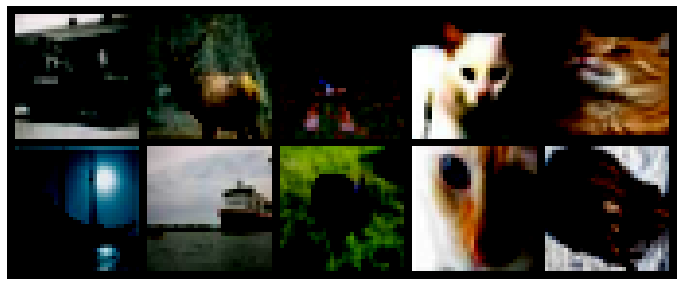

In [30]:
from torchvision.utils import make_grid
# Grab the first batch of 32 images
for images,classes in train_loader: 
    break

# Print the labels
print('Label:', classes[:10].numpy())
print('Class: ', *np.array([labels[i.item()] for i in classes[:10]]))

# Print the images
im = make_grid(images[:10], nrow=5)  # the default nrow is 8
plt.figure(figsize=(12,6))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))  # NOTE: PyTorch image format NCHW -> Channels first!
plt.axis("off")
plt.show()

In [99]:
print(images[0].shape) # channels first for PyTorch! matplotlib.pyplot.imshow() / TF expect NHWC

torch.Size([3, 32, 32])


In [46]:
import time


def train_cifar(hp, data_dir):
    start_time = time.time()
    train_loader, val_loader, _ = get_data(data_dir)
    model = ConvolutionalNetwork(hp) # define a net for this run
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    epochs = hp["epochs"]
    train_losses = []
    test_losses = []
    train_correct = []
    test_correct = []

    for i in range(epochs):
        trn_corr = 0
        tst_corr = 0
        
        # Run the training batches
        for b, (X_train, y_train) in enumerate(train_loader):
            b+=1
            
            # Apply the model
            y_pred = model(X_train)
            loss = criterion(y_pred, y_train)
    
            # Tally the number of correct predictions
            predicted = torch.max(y_pred.data, 1)[1]
            batch_corr = (predicted == y_train).sum()
            trn_corr += batch_corr
            
            # Update parameters
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Print interim results
            if b%25 == 0:
                print(f'epoch: {i:2}  batch: {b:4} loss: {loss.item():10.8f}\
                    accuracy: {trn_corr.item()*100/(32*b):7.3f}%')
            
        train_losses.append(loss)
        train_correct.append(trn_corr)
            
        # Run the testing batches
        with torch.no_grad():
            for b, (X_val, y_val) in enumerate(val_loader):

                # Apply the model
                y_pred = model(X_val)

                # Tally the number of correct predictions
                predicted = torch.max(y_pred.data, 1)[1] 
                tst_corr += (predicted == y_val).sum()
                
        loss = criterion(y_pred, y_val)
        test_losses.append(loss)
        test_correct.append(tst_corr/b)
    print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed  
    tune.report(loss=loss.item(), accuracy=tst_corr.item()*100/(32*b))  # Report results to ray.tune


In [44]:
# Search Space:

hp = {
    "conv1_width": tune.choice([3,6,9]),
    "conv2_width": tune.choice([9,18]),
    "epochs": 3 # We will only use 3 epoch for this trial
}

In [48]:
result = tune.run(
    tune.with_parameters(train_cifar, data_dir = __DATA_PATH / "cifar10"),
    config=hp,
    num_samples=3,
    local_dir = __DATA_PATH / "ray-tune",
    verbose=1
)

# NOTE: Check out that duration! Ray will multi thread when run locally 

2022-03-03 22:06:01,301	INFO tune.py:636 -- Total run time: 53.34 seconds (53.21 seconds for the tuning loop).


 pid=12712) cifar
 pid=12712) Duration: 51 seconds


In [50]:
result.dataframe()

,loss,accuracy,time_this_iter_s,done,timesteps_total,episodes_total,training_iteration,trial_id,experiment_id,date,...,pid,hostname,node_ip,time_since_restore,timesteps_since_restore,iterations_since_restore,config/conv1_width,config/conv2_width,config/epochs,logdir
0,1.088923,45.060484,33.737257,False,NaN,NaN,1,a941b_00000,8cf979a82393470a9d4e559c6b37aa53,2022-03-03_22-05-43,...,10152,DESKTOP-RL1C7R4,127.0.0.1,33.737257,0,1,9,18,3,c:\Users\Mike\Documents\Code\_MEng\645-enel\au...
1,0.930896,42.842742,50.601671,False,NaN,NaN,1,a941b_00001,0705e25d3f2245188aaa9c8a9601b58a,2022-03-03_22-06-01,...,12712,DESKTOP-RL1C7R4,127.0.0.1,50.601671,0,1,6,9,3,c:\Users\Mike\Documents\Code\_MEng\645-enel\au...
2,1.633716,39.516129,46.991674,False,NaN,NaN,1,a941b_00002,861e29a599a940539277a65666b49093,2022-03-03_22-05-57,...,10268,DESKTOP-RL1C7R4,127.0.0.1,46.991674,0,1,9,9,3,c:\Users\Mike\Documents\Code\_MEng\645-enel\au...


In [51]:
result.get_best_config(metric="accuracy", mode="max")

{'conv1_width': 9, 'conv2_width': 18, 'epochs': 3}